In [1]:
from tensorflow.keras import layers, models, backend, utils, metrics, preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics as skmetrics
import numpy as np
import seaborn as sns
import os
import pandas as pd
import glob
import errno
import scipy
from scipy import ndimage
import imageio


In [6]:
DIR_PREFIX  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/'

def load_dataset(path):
    dataset = {"image_path":[],"img_status":[],"where":[]}
    for status in os.listdir(path):
        for image in glob.glob(path+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append("train")
    dataset = pd.DataFrame(dataset)
    dataset.value_counts("img_status")
    real = dataset.value_counts("img_status")[1]
    fake = dataset.value_counts("img_status")[0]

    print(f"Real: {real},\nFake: {fake}\n")
    sns.countplot(dataset["img_status"])
    plt.show()
    return dataset

def view_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        plt.title(dataset.loc[random, "img_status"], size = 10) 
        plt.xticks([])
        plt.yticks([])

    plt.show()
    
def predict(img_path):
    input_arr = []
    count = 0
    image = preprocessing.image.load_img(
        img_path, grayscale=False, color_mode="rgb", target_size=(224, 224, 3)
    )
    i = preprocessing.image.img_to_array(image)
    input_arr = np.array([i])
    predictions = model.predict(input_arr)
    return predictions[0]

def predict_dataset(dataset):
    plt.figure(figsize = (14,10))
    for i in range(9):
        random = np.random.randint(1,len(dataset))
        plt.subplot(3,3,i+1)
        plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
        predicted = predict(dataset.loc[random,"image_path"]);
        plt.title(f"{dataset.loc[random, 'img_status']} accuracy: {predicted}", size = 10) 
        plt.xticks([])
        plt.yticks([])
    

def rotate_image(dir_name='train', deg=35):
    try:
        os.mkdir('./output/'+dir_name)
        os.mkdir('./output/'+dir_name+'/fake')
        os.mkdir('./output/'+dir_name+'/real')
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    i = 0
    print('data processed for '+dir_name)
    for filename in os.listdir(DIR_PREFIX+dir_name):
        f = os.path.join(DIR_PREFIX+dir_name, filename)
        # checking if it is a file
        if os.path.isdir(f):
            rotate_image(dir_name+'/'+filename, deg)
        else:
            i = i+1
            with Image.open(f) as im:
                im = im.rotate(deg)
                im.save(f.replace(DIR_PREFIX,'./output/'))
            print(i, end='\r')
            
try:
    os.mkdir('./output')
except OSError as exc:
    pass

Real: 4000,
Fake: 4000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


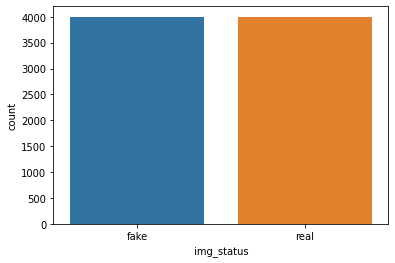

In [29]:
path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/train'
train_dataset = load_dataset(path)

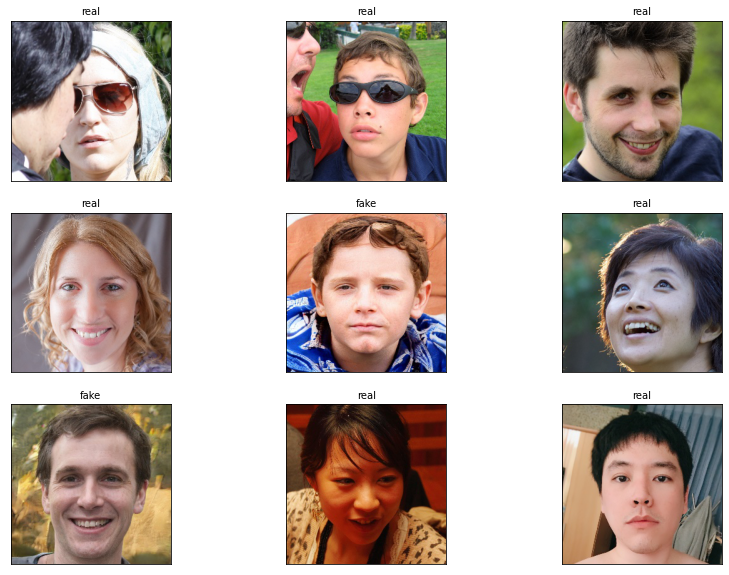

In [30]:
view_dataset(train_dataset)

In [37]:
rotate_image('valid', 75)
rotate_image('train', 75)


data processed for valid
data processed for valid/fake
data processed for valid/real
data processed for train
data processed for train/fake
data processed for train/real


Real: 4000,
Fake: 4000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


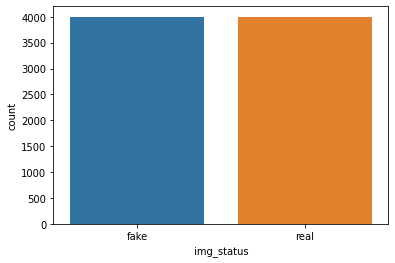

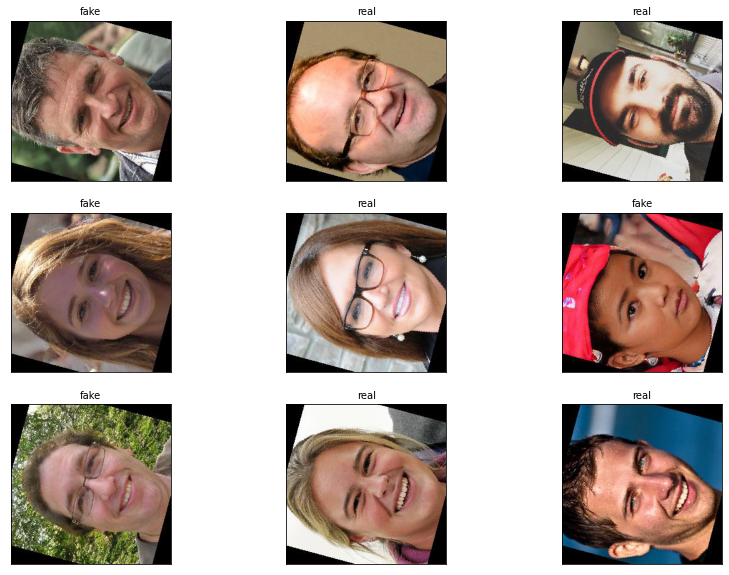

In [38]:
path  = './output/train'
train_dataset_preprocessed = load_dataset(path)
view_dataset(train_dataset_preprocessed)

In [39]:
base_path = './output/'
train_flow = preprocessing.image_dataset_from_directory(
    base_path + 'train/',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
test_flow = preprocessing.image_dataset_from_directory(
    '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
valid_flow = preprocessing.image_dataset_from_directory(
    base_path + 'valid/',
    image_size=(224, 224),
    batch_size=64,
    labels='inferred',
    label_mode='binary'
)
train_flow.class_names

Found 8000 files belonging to 2 classes.
Found 3587 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


['fake', 'real']

In [40]:
model = models.Sequential()

model.add(
    layers.Conv2D(32, (3, 3),activation='relu', input_shape=(224, 224, 3))
)

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
# output node 1 means prediction in 0 -- 1 and decimals
# output node 2 means predication of 0 or 1 no decimals
model.summary()

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = [
        'accuracy'
    ]
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 256)      

In [41]:
train_steps = 4000//64
valid_steps = 4000//64

hist = model.fit(
    train_flow,
    epochs=10,
    validation_data=valid_flow,
    batch_size=64
)

Epoch 1/10
125/125 [==============================] - 16s 117ms/step - loss: 2.0943 - accuracy: 0.5151 - val_loss: 0.6963 - val_accuracy: 0.5005
Epoch 2/10
125/125 [==============================] - 15s 114ms/step - loss: 0.6868 - accuracy: 0.5430 - val_loss: 0.6896 - val_accuracy: 0.5245
Epoch 3/10
125/125 [==============================] - 13s 99ms/step - loss: 0.6879 - accuracy: 0.5446 - val_loss: 0.6791 - val_accuracy: 0.5715
Epoch 4/10
125/125 [==============================] - 13s 99ms/step - loss: 0.6786 - accuracy: 0.5770 - val_loss: 0.6677 - val_accuracy: 0.5890
Epoch 5/10
125/125 [==============================] - 13s 97ms/step - loss: 0.6556 - accuracy: 0.6179 - val_loss: 0.6442 - val_accuracy: 0.6295
Epoch 6/10
125/125 [==============================] - 13s 99ms/step - loss: 0.6232 - accuracy: 0.6541 - val_loss: 0.6145 - val_accuracy: 0.6590
Epoch 7/10
125/125 [==============================] - 14s 108ms/step - loss: 0.5888 - accuracy: 0.6856 - val_loss: 0.6106 - val_accura

In [35]:
y_pred = model.predict(test_flow)
y_pred

array([[0.9635412 ],
       [0.9591626 ],
       [0.9896219 ],
       ...,
       [0.9970831 ],
       [0.93923515],
       [0.9963188 ]], dtype=float32)

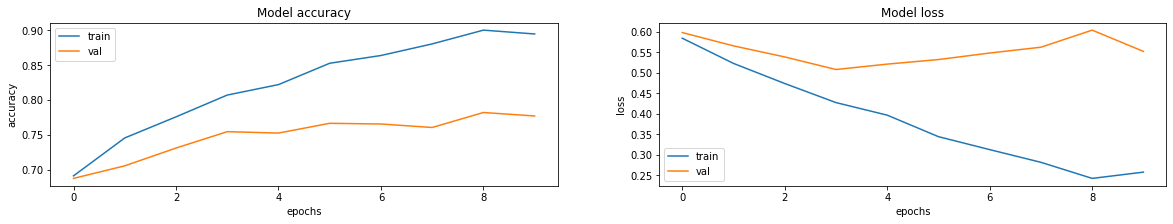

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate([ "accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [ ]:
# path  = '/kaggle/input/evendata/input/real_vs_fake/real-vs-fake/test'
# test_dataset = load_dataset(path)
# predict_dataset(test_dataset)